В этом наборе данных содержится информация о лесных пожарах, произошедших в Мексике. В нём указаны географическое положение, продолжительность, даты начала и окончания, типы пожаров, пострадавшая растительность, воздействие на окружающую среду и основные причины, а также другие характеристики. Анализ этих данных крайне важен для борьбы с пожарами и планирования превентивных мер.


In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("valamcortes/forest-fire-registry-of-mexico")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'forest-fire-registry-of-mexico' dataset.
Path to dataset files: /kaggle/input/forest-fire-registry-of-mexico


In [27]:
import pandas as pd
#path = "C:\\Users\\USER 1\\.cache\\kagglehub\\datasets\\valamcortes\\forest-fire-registry-of-mexico\\versions\\1"
df = pd.read_csv(path + "//Fires.csv", encoding='latin-1')
df.head()

,Year,Latitude,Longitude,State,Municipality,Region,Property,Start_Date,End_Date,Duration_days,Type_of_fire,Vegetation_type,Fire_regime,Impact_type,Adult_trees,Saplings,Shrubs,Herbaceous,Leaf_litter,Total_hectares,Size,Detection,Arrival,Duration,Cause
0,2015,20.369306,-104.546556,Jalisco,Atenguillo,West,El cuatillo,2015-01-01,2015-01-02,2 to 3 Days,Superficial,Oak Forest,Adapted,Minimal Impact,0.0,0.0,0.00,0.0,1.5,1.50,0 to 5 Hectares,00:09:5,00:35:0,07:00:00,Unknown
1,2015,19.307297,-99.092594,Ciudad de México,Xochimilco,Center,Ejidos de Xochimilco,2015-01-01,2015-01-01,1 Day,Superficial,Natural Grassland,Adapted,Minimal Impact,0.0,0.0,1.50,0.0,0.0,1.50,0 to 5 Hectares,00:08:0,00:40:0,02:50:00,Illicit Activities
2,2015,19.273358,-99.056281,Ciudad de México,Xochimilco,Center,San Gregorio Atlapulco,2015-01-01,2015-01-01,1 Day,Superficial,Unknown,Other,Minimal Impact,0.0,0.0,1.00,0.0,0.0,1.00,0 to 5 Hectares,00:04:5,00:15:0,24:20:00,Illicit Activities
3,2015,19.275750,-98.114833,Tlaxcala,Chiautempan,Center,Tlalcuapan,2015-01-01,2015-01-01,1 Day,Superficial,Pine Forest,Adapted,Minimal Impact,0.0,0.0,0.00,0.5,0.0,0.50,0 to 5 Hectares,00:06:0,00:24:5,01:41:00,Livestock Activities
4,2015,19.540444,-97.231556,Veracruz,Perote,Center,Ejido Perote,2015-01-01,2015-01-01,1 Day,Superficial,Pine Forest,Adapted,Minimal Impact,0.0,0.0,0.25,0.0,0.0,0.25,0 to 5 Hectares,00:20:0,00:35:0,25:59:59,Smokers


In [28]:
df.shape

(61072, 25)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61072 entries, 0 to 61071
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             61072 non-null  int64  
 1   Latitude         61072 non-null  float64
 2   Longitude        61072 non-null  float64
 3   State            61072 non-null  object 
 4   Municipality     61072 non-null  object 
 5   Region           61072 non-null  object 
 6   Property         61072 non-null  object 
 7   Start_Date       61072 non-null  object 
 8   End_Date         61072 non-null  object 
 9   Duration_days    61072 non-null  object 
 10  Type_of_fire     61072 non-null  object 
 11  Vegetation_type  61072 non-null  object 
 12  Fire_regime      61072 non-null  object 
 13  Impact_type      61072 non-null  object 
 14  Adult_trees      61072 non-null  float64
 15  Saplings         61072 non-null  float64
 16  Shrubs           61072 non-null  float64
 17  Herbaceous  

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, OPTICS

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score,
    homogeneity_score,
    completeness_score
)

In [31]:
# Вспомогательные функции

def cyclic_encode_seconds(seconds_series: pd.Series, period: float):
    """sin/cos кодирование циклической величины в секундах"""
    angle = 2 * np.pi * (seconds_series.astype(float) / period)
    return np.sin(angle), np.cos(angle)

def cyclic_encode_dayofyear(dates: pd.Series):
    """sin/cos для дня года (1..366)"""
    doy = pd.to_datetime(dates, errors="coerce").dt.dayofyear.astype(float)
    angle = 2 * np.pi * (doy / 366.0)
    return np.sin(angle), np.cos(angle)

def add_frequency_encoding(df: pd.DataFrame, col: str) -> pd.Series:
    """Частотное кодирование (доля встречаемости категории)"""
    freq = df[col].value_counts(dropna=False) / len(df)
    return df[col].map(freq).astype(float)

In [32]:
def best_match_accuracy(y_true, cluster_labels):
    """
    "Точность" после оптимального сопоставления кластеров и истинных классов.
    Это НЕ строгая метрика кластеризации, но полезна для интерпретации.
    Требует scipy.
    """
    from scipy.optimize import linear_sum_assignment

    y_true = pd.Series(y_true).astype("category")
    true_codes = y_true.cat.codes.to_numpy()

    # исключим шум DBSCAN (-1), чтобы не ломать матрицу
    mask = cluster_labels != -1
    true_codes = true_codes[mask]
    cluster_labels = cluster_labels[mask]

    # перенумеруем кластеры в 0..K-1
    uniq_clusters = np.unique(cluster_labels)
    cluster_map = {c:i for i,c in enumerate(uniq_clusters)}
    cl_codes = np.array([cluster_map[c] for c in cluster_labels], dtype=int)

    n_true = true_codes.max() + 1
    n_cl = cl_codes.max() + 1

    # confusion matrix
    cm = np.zeros((n_cl, n_true), dtype=int)
    for c, t in zip(cl_codes, true_codes):
        cm[c, t] += 1

    # Hungarian на максимизацию -> минимизация отрицательных
    row_ind, col_ind = linear_sum_assignment(-cm)
    matched = cm[row_ind, col_ind].sum()
    return matched / cm.sum()

In [33]:
# Удаляем неизвестные причины пожара
df = df[df['Cause'] != 'Unknown']

# Удаляем заведомо лишнее
drop_cols = ["Duration", "Size", "Duration_days"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Даты -> duration_days_num + циклический день года
df["Start_Date"] = pd.to_datetime(df["Start_Date"], errors="coerce")
df["End_Date"] = pd.to_datetime(df["End_Date"], errors="coerce")

# числовая длительность (если End < Start или NaT — станет NaN)
df['date_diff_days'] = (df['End_Date'] - df['Start_Date']).dt.days + 1
df["start_doy_sin"], df["start_doy_cos"] = cyclic_encode_dayofyear(df["Start_Date"])

# Удаляем некоторые выбросы как раньше
rows_to_drop = df[
    (df['Herbaceous'] < df['Herbaceous'].quantile(0.005)) | (df['Herbaceous'] > df['Herbaceous'].quantile(0.995)) |
    (df['Total_hectares']  < df['Total_hectares' ].quantile(0.005)) | (df['Total_hectares']  > df['Total_hectares' ].quantile(0.995)) |
    (df['date_diff_days'] < df['date_diff_days'].quantile(0.005)) | (df['date_diff_days'] > df['date_diff_days'].quantile(0.995)) |
    (df['date_diff_days'] <= 0)].index
df = df.drop(rows_to_drop)

# Удаление дат
df = df.drop(columns=["Start_Date", "End_Date"])

# Время обнаружения/прибытия -> циклическое время суток + время реакции

df["Detection_td"] = pd.to_timedelta(df["Detection"], errors="coerce")
df["Arrival_td"] = pd.to_timedelta(df["Arrival"], errors="coerce")

det_sec = df["Detection_td"].dt.total_seconds()
arr_sec = df["Arrival_td"].dt.total_seconds()

df["det_sin"], df["det_cos"] = cyclic_encode_seconds(det_sec, period=86400.0)

# время реакции с учетом перехода через 00:00
response_td = (df["Arrival_td"] - df["Detection_td"]) % pd.Timedelta(days=1)
df["response_seconds"] = response_td.dt.total_seconds()

df = df.drop(columns=["Detection", "Arrival", "Detection_td", "Arrival_td"])

# 4) Frequency encoding для многоктегориальных праметров (у остальных будет one-hot)
for hc in ["Property", "Municipality"]:
    if hc in df.columns:
        df[f"{hc}_freq"] = add_frequency_encoding(df, hc)

# Удаляем исходные эти категории
df = df.drop(columns=[c for c in ["Property", "Municipality"] if c in df.columns])

# 5) Целевая метка (не используется в обучении)
y = df["Cause"].copy()
X = df.drop(columns=["Cause"])

pd.set_option('display.max_columns', None)
df.head()

,Year,Latitude,Longitude,State,Region,Type_of_fire,Vegetation_type,Fire_regime,Impact_type,Adult_trees,Saplings,Shrubs,Herbaceous,Leaf_litter,Total_hectares,Cause,date_diff_days,start_doy_sin,start_doy_cos,det_sin,det_cos,response_seconds,Property_freq,Municipality_freq
1,2015,19.307297,-99.092594,Ciudad de México,Center,Superficial,Natural Grassland,Adapted,Minimal Impact,0.0,0.0,1.50,0.0,0.0,1.50,Illicit Activities,1,0.017166,0.999853,0.034899,0.999391,1920.0,0.000058,0.004767
2,2015,19.273358,-99.056281,Ciudad de México,Center,Superficial,Unknown,Other,Minimal Impact,0.0,0.0,1.00,0.0,0.0,1.00,Illicit Activities,1,0.017166,0.999853,0.017816,0.999841,655.0,0.000946,0.004767
3,2015,19.275750,-98.114833,Tlaxcala,Center,Superficial,Pine Forest,Adapted,Minimal Impact,0.0,0.0,0.00,0.5,0.0,0.50,Livestock Activities,1,0.017166,0.999853,0.026177,0.999657,1085.0,0.000425,0.005867
4,2015,19.540444,-97.231556,Veracruz,Center,Superficial,Pine Forest,Adapted,Minimal Impact,0.0,0.0,0.25,0.0,0.0,0.25,Smokers,1,0.017166,0.999853,0.087156,0.996195,900.0,0.000618,0.007720
6,2015,19.726972,-101.260972,Michoacán,West,Superficial,Subtropical Shrubland,Adapted,Minimal Impact,0.0,0.0,0.00,6.0,0.0,6.00,Livestock Activities,1,0.034328,0.999411,0.087156,0.996195,0.0,0.000019,0.005423


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51815 entries, 1 to 61071
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               51815 non-null  int64  
 1   Latitude           51815 non-null  float64
 2   Longitude          51815 non-null  float64
 3   State              51815 non-null  object 
 4   Region             51815 non-null  object 
 5   Type_of_fire       51815 non-null  object 
 6   Vegetation_type    51815 non-null  object 
 7   Fire_regime        51815 non-null  object 
 8   Impact_type        51815 non-null  object 
 9   Adult_trees        51815 non-null  float64
 10  Saplings           51815 non-null  float64
 11  Shrubs             51815 non-null  float64
 12  Herbaceous         51815 non-null  float64
 13  Leaf_litter        51815 non-null  float64
 14  Total_hectares     51815 non-null  float64
 15  Cause              51815 non-null  object 
 16  date_diff_days     51815 no

In [37]:
# Категориальные (оставшиеся object) и числовые
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# One-hot только для НЕбольших категорий
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)
X_pre = preprocessor.fit_transform(X)
print(X_pre.shape)


(51815, 133)


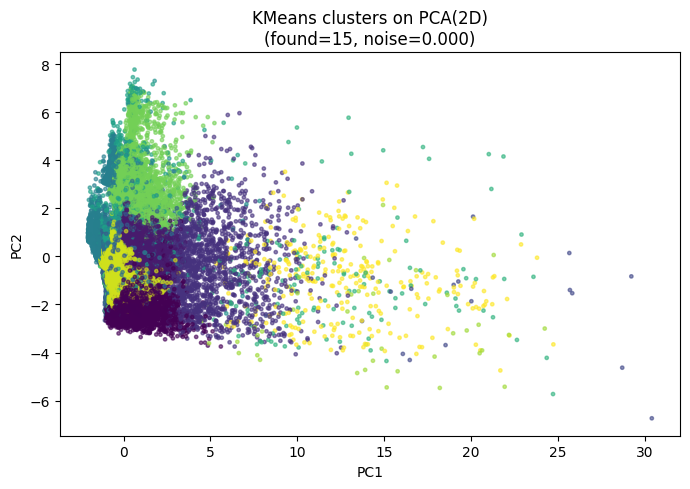

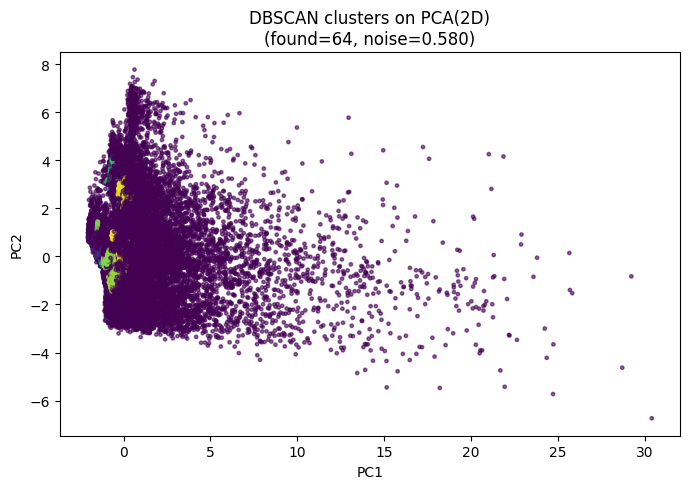

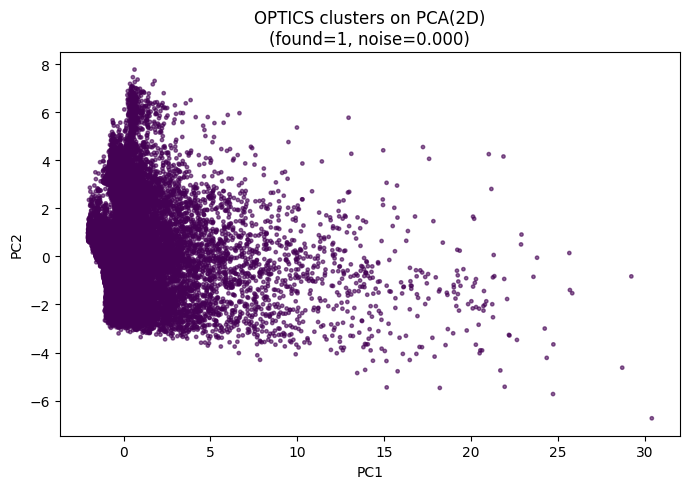

   method  n_clusters_found  noise_frac       ARI       NMI  V-measure  \
0  KMeans                15    0.000000  0.020616  0.065124   0.065124   
2  OPTICS                 1    0.000000  0.000000  0.000000   0.000000   
1  DBSCAN                64    0.580257 -0.018630  0.077779   0.077779   

   Homogeneity  Completeness  BestMatchAcc  
0     0.069552      0.061226      0.192531  
2     0.000000      1.000000      0.284474  
1     0.076311      0.079304      0.153294  


In [39]:
#увеличение и уменьшение pac_dim не влияет концептуально на результат
pca_dim = 20
# PCA для кластеризации (20 измерений по умолчанию)
pca = PCA(n_components=pca_dim, random_state=42)

# Общая матрица признаков для кластеризации
X_pca = pca.fit_transform(X_pre)

# PCA 2D для визуализации
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_pre)

# --- 3 метода кластеризации ---
models = {
    "KMeans": KMeans(n_clusters=15, random_state=42, n_init="auto"),
    # В DBSCAN параметры обычно подбирают по k-distance plot, тут стартовые:
    "DBSCAN": DBSCAN(eps=0.6, min_samples=15),
    # OPTICS как "третий": плотностной метод, часто устойчивее DBSCAN
    "OPTICS": OPTICS(min_samples=15, xi=0.05, min_cluster_size=0.02),
}

results = []

for name, model in models.items():
    labels = model.fit_predict(X_pca)

    # Метрики (Cause не использовалась в fit!)
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)
    vms = v_measure_score(y, labels)
    hom = homogeneity_score(y, labels)
    comp = completeness_score(y, labels)

    # n_clusters_found:
    # число найденных кластеров (без учёта шума -1 у DBSCAN/OPTICS);
    # показывает, насколько "детально" метод разделил данные

    # noise_frac:
    # доля объектов, помеченных как шум (label = -1);
    # актуально для плотностных методов: чем выше, тем больше точек не вошло ни в один кластер

    # ARI (Adjusted Rand Index):
    # согласованность кластеров и истинных классов на уровне пар объектов;
    # скорректирован на случайность: 1 - идеально, 0 - случайно, < 0 - хуже случайного

    # NMI (Normalized Mutual Information):
    # насколько много информации об истинных классах содержит разбиение на кластеры;
    # 0 - независимы, 1 - совпадают

    # V-measure:
    # гармоническое среднее Homogeneity и Completeness;
    # высокое значение означает, что кластеры одновременно "чистые" и не дробят классы

    # Homogeneity:
    # "чистота" кластеров: в каждом кластере в основном один истинный класс;
    # может быть высокой при большом числе мелких кластеров

    # Completeness:
    # "собранность" классов: объекты одного истинного класса попадают в один кластер;
    # может быть высокой, если кластеров мало (например, один общий кластер)

    row = {
        "method": name,
        "n_clusters_found": len(set(labels)) - (1 if -1 in labels else 0),
        "noise_frac": float(np.mean(labels == -1)),
        "ARI": ari,
        "NMI": nmi,
        "V-measure": vms,
        "Homogeneity": hom,
        "Completeness": comp,
    }

    try:
        row["BestMatchAcc"] = best_match_accuracy(y, labels)
    except Exception:
        row["BestMatchAcc"] = np.nan

    results.append(row)

    # Визуализация PCA 2D
    plt.figure(figsize=(7, 5))
    plt.scatter(X_pca2[:, 0], X_pca2[:, 1], s=6, alpha=0.6, c=labels)
    plt.title(f"{name} clusters on PCA(2D)\n(found={row['n_clusters_found']}, noise={row['noise_frac']:.3f})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results).sort_values(by="ARI", ascending=False)
print(results_df)

##Выводы
1) Причина пожара (Cause) практически **не образует кластерную структуру** в пространстве используемых признаков, потому что
- ARI ≈ 0 или отрицателен у всех методов
- NMI < 0.08 — крайне слабая взаимная информация
- V-measure ≈ NMI → классы и кластеры почти независимы

2) KMeans выделяет группы со схожими средними значениями признаков, однако данные группы практически не соответствуют причинам пожаров. Это указывает на отсутствие компактных, сферических кластеров, ассоциированных с конкретными причинами возникновения пожаров.

3) OPTICS не выявил плотностной структуры в данных при выбранных параметрах, что свидетельствует об отсутствии устойчивых кластеров различной плотности в пространстве признаков.

4) DBSCAN выявляет локальные плотные подмножества наблюдений, однако данные кластеры не соответствуют истинным причинам пожаров. Значительная доля объектов классифицируется как шум, что указывает на отсутствие чётко выраженной плотностной структуры.

5) Изменение pca_dim концпептуально ничего не меняет. Данные не предрасполагают к качественной кластеризации, впрочем как и классификации (из предыдущей дз)